In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
blacklist = pd.read_table('features/blacklist.tsv')['feature'].values
feature_df = pd.read_table('features/transformed-replacement-features.tsv.bz2')

/home/mmayers/projects/wikidata/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
feature_df.drop(blacklist, axis=1, inplace=True)

In [4]:
feature_df.head(2)

,compound_id,disease_id,compound_name,disease_name,category,status,prior_prob,prior_logit,degree_CbG,degree_CcSE,...,dwpc_CuG<rGiGaD,dwpc_CuGaDuGaD,dwpc_CuGcG<rGaD,dwpc_CuGcGiGaD,dwpc_CuGdDpSpD,dwpc_CuGr>GbCtD,dwpc_CuGuCtD,dwpc_CuGuCtDrD,dwpc_CuGuCuGaD,dwpc_CuGuDuGaD
0,DB01048,DOID:10652,Abacavir,Alzheimer's disease,NaN,0,0.004753,-5.344,-0.2955,0.8146,...,-0.6116,-0.5016,-0.4211,-0.4581,-0.5323,-0.3328,-0.3712,-0.5534,-0.5377,-0.4953
1,DB05812,DOID:10652,Abiraterone,Alzheimer's disease,NaN,0,0.004753,-5.344,0.5495,0.5554,...,-0.6116,-0.5016,-0.4211,-0.4581,-0.5323,-0.3328,-0.3712,-0.5534,-0.5377,-0.4953


In [5]:
train_df = feature_df[feature_df['prior_prob'] > 0]

X_train = train_df.iloc[:,7:].values
feature_names = train_df.iloc[:, 7:].columns.values
print(X_train.shape)

y_train = train_df['status'].values

(29799, 138)


In [6]:
X_train

array([[-5.344  , -0.2955 ,  0.8146 , ..., -0.5534 , -0.5377 , -0.4953 ],
       [-5.344  ,  0.5495 ,  0.5554 , ..., -0.5534 , -0.5377 , -0.4953 ],
       [-5.344  ,  0.9053 ,  1.022  , ..., -0.5534 , -0.5377 , -0.4953 ],
       ..., 
       [-6.756  ,  0.5495 ,  0.4312 , ...,  1.952  , -0.411  , -0.09403],
       [-6.027  ,  0.2984 ,  1.028  , ..., -0.5534 , -0.5377 , -0.4953 ],
       [-6.756  ,  1.823  ,  1.087  , ..., -0.5534 , -0.4626 , -0.4953 ]])

In [7]:
pen = np.array([0 if x == 'prior_logit' else 1 for x in feature_names])

    hetior::glmnet_train(X = X_train, y = y_train, alpha = 0.2, s = lambda, cores = 10, seed = 0,
      penalty.factor=penalty, lambda.min.ratio=1e-8, nlambda=150, standardize=TRUE)
        
      fit$cv_model <- glmnet::cv.glmnet(x = X, y = y, weights = w, family='binomial',
        alpha=alpha, parallel=TRUE, ...)
        

In [9]:
from glmnet import LogitNet

In [10]:
ln = LogitNet(alpha=0.2, n_jobs=-1, min_lambda_ratio=1e-8, n_lambda=150, standardize=True, 
              random_state=0, scoring='roc_auc')

In [11]:
ln.fit(X_train, y_train, relative_penalties=pen)

LogitNet(alpha=0.2, cut_point=1.0, fit_intercept=True, lambda_path=None,
     max_iter=100000, min_lambda_ratio=1e-08, n_jobs=-1, n_lambda=150,
     n_splits=3, random_state=0, scoring='roc_auc', standardize=True,
     tol=1e-07, verbose=False)

In [12]:
ln.lambda_best_

array([ 0.00046676])

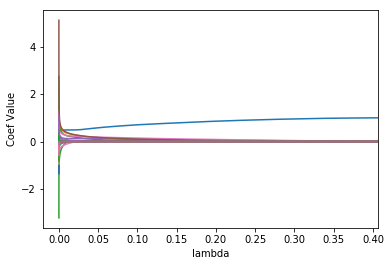

In [13]:
for i in range(ln.coef_path_.shape[1]):
    plt.plot(ln.lambda_path_, ln.coef_path_[0, i, :])

ax = plt.gca()
ax.set_xlim(right=ln.lambda_path_.max())
ax.set_xlabel("lambda")
ax.set_ylabel("Coef Value")
#ax.invert_xaxis()
#ax.set_ylim(-.2,.2)
plt.show()

In [14]:
# Prior_logit coeff
ln.coef_[0][0]

0.3882099353606967

In [15]:
feature_df['prior_prob'].sum()

754.99027499999988

In [16]:
'{:0.4%}'.format(feature_df['status'].mean())

'0.3610%'

In [17]:
sum(ln.coef_[0] > 0), sum(ln.coef_[0] < 0)

(20, 40)

In [18]:
from scipy.special import logit

In [19]:
X_all = feature_df.iloc[:,7:].values
X_all[:,0] = logit(feature_df['status'].mean())

In [20]:
y_predicted = ln.predict_proba(X_all)[:,1]

In [21]:
y_predicted.shape

(209168,)

In [22]:
y_predicted.mean()

0.0031229301822754438

In [23]:
train_pred_df = train_df.loc[:,['compound_id', 'disease_id']]
train_pred_df['training_prediction'] = ln.predict_proba(X_train)[:,1]

In [24]:
predict_df = feature_df.iloc[:,:7]
print(predict_df.shape)
predict_df['prediction'] = y_predicted
predict_df = predict_df.merge(train_pred_df, how='left', on=['compound_id', 'disease_id'])

(209168, 7)


In [25]:
def add_percentile_column(in_df, group_col, new_col, cdst_col='prediction'):


    grpd = in_df.groupby(group_col)
    predict_dfs = []

    for grp, df1 in grpd:
        df = df1.copy()

        total = df.shape[0]

        df.sort_values(cdst_col, inplace=True)
        order = np.array(df.reset_index(drop=True).index)

        percentile = (order+1) / total
        df[new_col] = percentile

        predict_dfs.append(df)

    return pd.concat(predict_dfs)

In [26]:
predict_df = add_percentile_column(predict_df, group_col='compound_id', new_col='compound_percentile')
predict_df = add_percentile_column(predict_df, group_col='disease_id', new_col='disease_percentile')

In [27]:
predict_df = predict_df.merge(pd.read_table('../validate/validation-statuses.tsv')
                              .drop(['compound_name', 'disease_name'], axis=1),
                          how='left', on=['compound_id', 'disease_id'])

In [28]:
predict_df = predict_df.sort_values('prediction', ascending=False).reset_index(drop=True)
predict_df.head(2)

,compound_id,disease_id,compound_name,disease_name,category,status,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral
0,DB01273,DOID:0050742,Varenicline,nicotine dependence,DM,1,0.001162,0.999984,0.999975,1.0,1.0,NaN,NaN,NaN
1,DB00284,DOID:9352,Acarbose,type 2 diabetes mellitus,DM,1,0.029250,0.999983,0.999993,1.0,1.0,NaN,NaN,NaN


In [29]:
from sklearn.metrics import average_precision_score, roc_auc_score

In [30]:
out_dat = []

for y_pred in ['prediction', 'compound_percentile', 'disease_percentile', 'training_prediction', 'prior_prob']:
    for y_true in ['status', 'status_drugcentral', 'status_trials']:
        vtm_df = predict_df[[y_true, y_pred]].dropna(axis=0)
        
        y_true_vals = vtm_df[y_true].values
        y_pred_vals = vtm_df[y_pred].values
        
        
        n_pos = len(np.where(y_true_vals==1)[0])
        n_neg = len(np.where(y_true_vals==0)[0])
        
        auroc = roc_auc_score(y_true_vals, y_pred_vals)
        auprc = average_precision_score(y_true_vals, y_pred_vals)
        tjur = vtm_df[vtm_df[y_true]==1][y_pred].mean() - vtm_df[vtm_df[y_true]==0][y_pred].mean()
        
        out_dat.append({'y_true_var': y_true, 'y_pred_var': y_pred, 'n_pos': n_pos, 'n_neg':n_neg,
                       'auroc': auroc, 'auprc': auprc, 'tjur':tjur})
perf_df = pd.DataFrame(out_dat)[['y_true_var', 'y_pred_var', 'n_pos', 'n_neg', 'auroc', 'auprc', 'tjur']].sort_values('y_pred_var')

In [31]:
perf_df

,y_true_var,y_pred_var,n_pos,n_neg,auroc,auprc,tjur
3,status,compound_percentile,755,208413,0.984232,0.385547,0.484232
4,status_drugcentral,compound_percentile,208,207572,0.811985,0.150045,0.311663
5,status_trials,compound_percentile,5594,202186,0.623373,0.057201,0.122937
6,status,disease_percentile,755,208413,0.994487,0.407664,0.494487
7,status_drugcentral,disease_percentile,208,207572,0.734798,0.003798,0.233908
8,status_trials,disease_percentile,5594,202186,0.527550,0.043316,0.027471
0,status,prediction,755,208413,0.999997,0.998967,0.841030
1,status_drugcentral,prediction,208,207572,0.825337,0.025639,0.011404
2,status_trials,prediction,5594,202186,0.594602,0.093422,0.001242
12,status,prior_prob,755,208413,0.979166,0.162854,0.106842


In [32]:
def glmnet_coefs(glmnet_obj, X, y):
    l = glmnet_obj.lambda_best_[0]
    
    coef = glmnet_obj.coef_[0]
    coef = np.insert(coef, 0, glmnet_obj.intercept_)
    
    names = np.insert(feature_names, 0, 'intercept')
    
    z_intercept = coef[0] + sum(coef[1:] * X.mean(axis=0))
    z_coef = coef[1:] * X.std(axis=0)
    z_coef = np.insert(z_coef, 0, z_intercept)
    
    return pd.DataFrame([names, coef, z_coef]).T.rename(columns={0:'feature', 1:'coef', 2:'zcoef'})
    

In [33]:
perf_df.to_csv('predictions/performance_py-replacement.tsv', sep='\t', index=False)
glmnet_coefs(ln, X_train, y_train).to_csv('model/coefficient_py-replacement.tsv', sep='\t', index=False)
predict_df.to_csv('predictions/probabilities_py-replacement.tsv', sep='\t', index=False)

In [34]:
coef = glmnet_coefs(ln, X_train, y_train)
coef.sort_values('coef', ascending=False)

,feature,coef,zcoef
126,dwpc_CtDtCtD,1.14918,2.75481
32,dwpc_CbGbCtD,0.841876,1.16821
73,dwpc_CcSEcCtD,0.7471,0.747082
117,dwpc_CrCrCtD,0.499049,0.827762
1,prior_logit,0.38821,0.528339
135,dwpc_CuGuCtD,0.341876,0.540321
83,dwpc_CdGdCtD,0.226921,0.349797
14,degree_DrD,0.165167,0.161701
95,dwpc_CiPCiCtD,0.151365,0.327165
11,degree_DlA,0.0798231,0.071014
